In [1]:
######################################## Install packages ########################################

import pandas as pd
import numpy as np
# Create chunks
import re

# Model
import spacy
import medspacy
from medspacy.ner import TargetRule
from fuzzywuzzy import fuzz

# Performance
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import snowflake.connector

In [2]:
######################################## Connect to Snowflake ########################################

# Establish a connection
conn = snowflake.connector.connect(
    user='dana_george@hakkoda.io',
    authenticator='externalbrowser',
    account='ska04930.east-us-2.azure',
    warehouse='DATASCIENCE_WH',
    database='ONCOEMR_RAW_DEV',
    schema='DBO',
    role='ACCOUNTADMIN'
)

# Run a test query
cursor = conn.cursor()
cursor.execute("SELECT CURRENT_VERSION()")
row = cursor.fetchone()
print("Snowflake version:", row[0])

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/bbaf0319-e615-416f-8870-f7eacf074b66/saml2?SAMLRequest=nZJBc9owEIX%2Fikc9y5aNMaABMiaUhpSmFEgyk5uwZaJBllytHCf99ZUNzKSH5NCbRnq739O%2BHV%2B9ltJ74QaEVhMU%2BgR5XGU6F%2BowQfe7BR4iDyxTOZNa8Ql644CupmNgpaxoWttnteG%2Faw7Wc40U0PZhgmqjqGYggCpWcqA2o9v0x4pGPqEMgBvrcOhckoNwrGdrKxoETdP4Tc%2FX5hBEhJCAjAKnaiVf0DtE9TmjMtrqTMtLyav70weIMCBxi3AKR1ifC2dCnUbwGWV%2FEgG92e3WeP1zu0NeevndtVZQl9xsuXkRGb%2FfrE4GwDmAIyPxqEd8zsDiGnDksz%2B14T4o3RSSHXmmy6q2rrnvTkHB80Dqg3AjW84nqDqK%2FKG%2FuVvo74fjfPa0J4%2FV7bd0Nk%2BJzNkw%2BpXd5MlXqLeb1ePt6Jgh7%2BEScNQGvASo%2BVK1sVp3RaIYhyEO%2B7twSPsRjRO%2FF5Mn5M1drEIx21VevHc%2B%2FFJkRoMurFZSKN653O9ZQXrhCPMk7OM4TAo8HA4ILgacZQUZxPskCdrwInRaINoZMdP%2FHMs4eN%2FkvJJ3LqXlfK2lyN68hTYlsx%2BHGPphdyNyXHRSyksmZJrnhgO4MK

In [3]:
######################################## Load Data ########################################

# Get sample patient ids
cursor = conn.cursor()
cursor.execute("""
    SELECT DISTINCT "patientid" FROM ONCOEMR_RAW_DEV.DBO.DEMOGRAHPICS
    ORDER BY RANDOM();
""")
sample_patient_ids = [row[0] for row in cursor.fetchall()]
sample_patient_ids = [f"'{id}'" if isinstance(id, str) else str(id) for id in sample_patient_ids]

cursor = conn.cursor()
cursor.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'DBO'
    AND table_catalog = 'ONCOEMR_RAW_DEV'
    AND table_type = 'BASE TABLE';
""")

# Fetch all the table names
tables = [row[0] for row in cursor.fetchall()]
#print(tables)

# Create a dictionary to hold each table as a DataFrame
table_dataframes = {}
table_dataframes_spat = {}

for table in tables:
    # First, check if the table contains 'patientid' by querying the columns of the table
    cursor.execute(f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'DBO' AND table_name = '{table}'
    """)
    
    columns = [row[0] for row in cursor.fetchall()]
    
    # If 'patientid' is a column, proceed to query the table
    if 'patientid' in columns:
        query = f"""
            SELECT *
            FROM ONCOEMR_RAW_DEV.DBO.{table}
            WHERE "patientid" IN ({', '.join(map(str, sample_patient_ids))})
        """
        cursor.execute(query)
        
        # Fetch the result and convert it to a DataFrame
        results = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        table_dataframes[table] = pd.DataFrame(results, columns=columns)

    # If 'spatientid' is a column, proceed to query the table
    if 'spatientid' in columns:
        query = f"""
            SELECT *
            FROM ONCOEMR_RAW_DEV.DBO.{table}
            WHERE "spatientid" IN ({', '.join(map(str, sample_patient_ids))})
        """
        cursor.execute(query)
        
        # Fetch the result and convert it to a DataFrame
        results_spat = cursor.fetchall()
        columns_spat = [desc[0] for desc in cursor.description]
        table_dataframes_spat[table] = pd.DataFrame(results_spat, columns=columns_spat)

# Merge table_dataframes_spat into table_dataframes_pat
table_dataframes.update(table_dataframes_spat)

# Now table_dataframes_pat contains all the tables from both dictionaries
print("Tables Loaded:")
for table, df in table_dataframes.items():
    print(f"{table}")
    #print(df.head())

# Loop through the dictionary to create a separate DataFrame variable for each key
for table, df in table_dataframes.items():
    globals()[table] = df

# Now you can access the DataFrames as individual variables:
# print(ADMINISTRATIONS.head())

# Bring in clinical trial data
clinical_trials_excl = pd.read_csv('clinical_trials_data_simple_exclusion.csv')
clinical_trials_incl = pd.read_csv('clinical_trials_data_simple_inclusion_75.csv')
print("clinical_trials_data_simple_exclusion")
print("clinical_trials_data_simple_inclusion")
print(" ")
print("Data Loaded Successfully!")

Tables Loaded:
ADMINISTRATIONS
ADVANCEDIRECTIVES
ALLERGY
CHARGE
DEMOGRAHPICS
DEMOGRAPHICS
DIAGNOSIS
DISEASESTATUS
ERX
FAMILYHISTORY
HOSPITALIZATION
INSURANCE
LABS
ORDERS
RADIOLOGY
REFERRINGPROVIDER
SOCIALHISTORY
TRANSFUSION
GRADESCALES
SURGICALHISTORY
PERFORMANCE
VISIT
BIOMARKERS
TOXICITIES
MEDICATIONLIST
STAGING
DATA_HISTORY
PATIENT_LOCATION_HISTORY
ORDER_CHARGE_HISTORY
TREATMENT_CURRENT_HISTORY
VITAL_SIGN_HISTORY
TREATMENT_PREVIOUS_HISTORY
clinical_trials_data_simple_exclusion
clinical_trials_data_simple_inclusion
 
Data Loaded Successfully!


In [4]:
def print_columns_of_dict_of_dfs(df_dict):
    """Prints the columns of each DataFrame in a dictionary of DataFrames."""

    for df_name, df in df_dict.items():
        print(f"Columns of {df_name}:")
        print(df.columns)
        print("-" * 20)

# Call the function to print the columns
print_columns_of_dict_of_dfs(table_dataframes)

Columns of ADMINISTRATIONS:
Index(['clientid', 'administrationid', 'diagnosisid', 'doseadministered',
       'doseapproved', 'drugname', 'duration', 'intent', 'endreason', 'form',
       'targetdrugname', 'targetdrugshortname', 'targetdrugcategory', 'ndc',
       'nodosestaken', 'orderedamount', 'ordereddate', 'administeredunits',
       'targetadministeredunits', 'orderid', 'patientid', 'plannedcycles',
       'providerid', 'orderhassignoff', 'orderstatus', 'regimen', 'route',
       'targetroute', 'locationid', 'startdate', 'stopdate',
       'transactiontimestamp', 'lineoftx', 'visitid', 'administrationdate',
       'clinicalstudydrugind', 'clinicalstudyregimenind',
       'compassionatecaredrugind', 'targetdiagnosiscode',
       'targetdiagnosiscodesys', 'antineoplasticind',
       'targetclinicalstudyregimenind'],
      dtype='object')
--------------------
Columns of ADVANCEDIRECTIVES:
Index(['clientid', 'patientid', 'advancedirectiveid', 'dnr', 'lw', 'dpa',
       'transactiontim

In [5]:
######################################## Feature Engineering ########################################

# Convert non-numeric values to NaN
DEMOGRAPHICS['age'] = pd.to_numeric(DEMOGRAPHICS['age'], errors='coerce')

# Now, convert the column to integers (NaNs will remain as NaN)
DEMOGRAPHICS['age'] = DEMOGRAPHICS['age'].fillna(-1).astype(int)  # You can replace -1 with another placeholder value if needed

print("Feature Engineering Complete!")

Feature Engineering Complete!


In [6]:
######################################## Quality Check ########################################

print(clinical_trials_incl.columns)
print(DEMOGRAPHICS)

Index(['Trial_Name', 'Trial_ID', 'Inclusion_Criteria'], dtype='object')
      RowID clientid                             patientid patientmrn  \
0    112304   CA0026  D6288764-EBAB-429D-9D6E-BA5152340FDD       None   
1    158902   CA0026  548CD51B-9AC0-4A25-9D48-B6D08675DD00       None   
2       924   CA0026  A552A6C5-63DB-4152-B0E3-4C1A94C9CF27       None   
3    109938   CA0026  ECCE7682-F192-4E4B-8915-D3808F81E60E       None   
4    131886   CA0026  B995B177-DA99-4BEF-9818-8E40DCD9841D       None   
..      ...      ...                                   ...        ...   
995     148   CA0026  9D1DAE72-E47F-453C-AF06-12AA2B97855C       None   
996     228   CA0026  E393B5A7-862D-43DD-97A2-4B2075FBD297       None   
997     398   CA0026  F90AA3C5-D2D7-4A6E-AFC5-024A1F912112       None   
998     878   CA0026  BE19FCC3-3107-400D-9C0B-1A6C3ADB8D5E       None   
999     275   CA0026  F124E3E2-C129-4FA2-8144-BF11CEC44CFB       None   

    patientssn         primaryphysicianid   dob  bi

In [7]:
######################################## Build Mock Expert Decision ########################################
# Perform the LEFT JOIN
merged_df = DEMOGRAPHICS.merge(DIAGNOSIS, on='patientid', how='left')

# Filter using "LIKE" equivalent
eligible = merged_df[
    (merged_df['age'] >= 75) &
    (merged_df['gender'] == 'Female') &
    (merged_df['targetdetaileddiagnosisgroup'].str.contains('lung', case=False, na=False)) &
    (merged_df['targetdetaileddiagnosisgroup'].str.contains('cancer', case=False, na=False))
]

#eligible['Expert Decision'] = 1

# Extract patient IDs that match the expert's eligibility criteria
eligible_patient_ids = eligible['patientid'].tolist()

# Get patient IDs that are not in the eligible list
ineligible_patient_ids = merged_df[~merged_df['patientid'].isin(eligible_patient_ids)]['patientid'].unique().tolist()

# SELECT * FROM DEMOGRAPHICS
# LEFT JOIN DIAGNOSIS ON PATIENTID
# WHERE AGE >= 18 AND GENDER = 'FEMALE'
# AND DIAGNOSIS like LUNG CANCER

In [8]:
print(len(eligible_patient_ids))
print(len(ineligible_patient_ids))

6
993


In [9]:
######################################## MedSpacy Model ########################################

# Load medspaCy
nlp = medspacy.load()

# Define custom rules for categorizing inclusion criteria
target_rules = [
    TargetRule("age", pattern=[{"LOWER": {"IN": ["age", "aged", "year", "old"]}}], category="AGE"),
    TargetRule("gender", pattern=[{"LOWER": {"IN": ["male", "female"]}}], category="GENDER"),
    TargetRule("diagnosis", pattern=[{"LOWER": {"IN": ["stage", "nsclc", "cancer", "tumor"]}}], category="DIAGNOSIS"),
    # TargetRule("treatment", pattern=[{"LOWER": {"IN": ["treatment", "therapy", "medication", "chemotherapy", "osimertinib"]}}], category="TREATMENT"),
    # TargetRule("performance", pattern=[{"LOWER": {"IN": ["ecog", "performance", "status"]}}], category="PERFORMANCE_STATUS"),
    # TargetRule("lab_value", pattern=[{"LOWER": {"IN": ["anc", "platelet", "neutrophil", "creatinine", "bilirubin", "ast", "alt"]}}], category="LAB_VALUE"),
    # TargetRule("reproductive", pattern=[{"LOWER": {"IN": ["pregnant", "contraception", "childbearing"]}}], category="REPRODUCTIVE"),
    # TargetRule("administrative", pattern=[{"LOWER": {"IN": ["consent", "signed"]}}], category="ADMINISTRATIVE"),
]

# Add the custom rules to the NER component
nlp.get_pipe("medspacy_target_matcher").add(target_rules)

def classify_criterion(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return None
    doc = nlp(text)
    categories = set([ent.label_ for ent in doc.ents])
    if categories:
        return ", ".join(categories)
    else:
        return "OTHER"

# Apply the classification function to create a new column
clinical_trials_incl['Category'] = clinical_trials_incl['Inclusion_Criteria'].apply(classify_criterion)

# Display the result
pd.set_option('display.max_colwidth', None)
print(clinical_trials_incl[['Trial_ID', 'Inclusion_Criteria', 'Category']])

   Trial_ID          Inclusion_Criteria   Category
0       123            Aged 75 or over.        AGE
1       123                      Female     GENDER
2       123  Diagnosed with Lung Cancer  DIAGNOSIS


In [10]:
######################################## FuzzyWuzzy Model ########################################

# Define a mapping of categories to relevant tables
category_table_mapping = {
    'AGE': ['DEMOGRAPHICS'],
    'GENDER': ['DEMOGRAPHICS'],
    'DIAGNOSIS': ['DIAGNOSIS', 'DISEASESTATUS']
    # 'TREATMENT': ['ADMINISTRATIONS', 'ORDERS', 'MEDICATIONLIST', 'TREATMENT_CURRENT_HISTORY', 'TREATMENT_PREVIOUS_HISTORY'],
    # 'PERFORMANCE_STATUS': ['PERFORMANCE'],
    # 'LAB_VALUE': ['LABS'],
    # 'REPRODUCTIVE': ['DEMOGRAPHICS', 'SOCIALHISTORY'],
    # 'ADMINISTRATIVE': ['ADVANCEDIRECTIVES'],
    # 'OTHER': ['ALLERGY', 'CHARGE', 'ERX', 'FAMILYHISTORY', 'HOSPITALIZATION', 'INSURANCE', 'RADIOLOGY', 'REFERRINGPROVIDER', 'TRANSFUSION', 'GRADESCALES', 'SURGICALHISTORY', 'VISIT', 'BIOMARKERS', 'TOXICITIES', 'STAGING', 'DATA_HISTORY', 'PATIENT_LOCATION_HISTORY', 'ORDER_CHARGE_HISTORY', 'VITAL_SIGN_HISTORY']
}

def get_patient_data(patient_id, table, df, tables_without_data):
    # Check if 'patientid' or 'spatientid' column exists
    patient_id_col = 'patientid' if 'patientid' in df.columns else 'spatientid' if 'spatientid' in df.columns else None
    
    if patient_id_col is None:
        print(f"Warning: Neither 'patientid' nor 'spatientid' column found in {table} table. Returning all data.")
        return df.values.flatten().tolist(), tables_without_data
    
    # Filter the dataframe for the specific patient
    patient_df = df[df[patient_id_col] == patient_id]
    
    # If no data found for the patient, add to tables_without_data and return an empty list
    if patient_df.empty:
        tables_without_data.add(table)
        return [], tables_without_data
    
    # Select relevant columns based on the table
    if table == 'DEMOGRAPHICS':
        columns = ['age', 'gender']
    elif table == 'DIAGNOSIS':
        columns = ['targetdetaileddiagnosisgroup']
    # elif table == 'ADMINISTRATIONS':
    #     columns = ['drugname']
    # elif table == 'PERFORMANCE':
    #     columns = ['targetperformancescale', 'targetperformancevalue']
    # elif table == 'LABS':
    #     columns = ['test', 'testresult', 'testunits']
    # elif table == 'ADVANCEDIRECTIVES':
    #     columns = ['dnr', 'lw', 'dpa']
    else:
        # For other tables, return all columns
        return patient_df.values.flatten().tolist(), tables_without_data
    
    # Check if all specified columns exist in the dataframe
    existing_columns = [col for col in columns if col in patient_df.columns]
    if not existing_columns:
        print(f"Warning: None of the specified columns found in {table} table. Returning all data.")
        return patient_df.values.flatten().tolist(), tables_without_data
    
    return patient_df[existing_columns].values.flatten().tolist(), tables_without_data

def fuzzy_match_criteria(patient_id, criterion, category, tables, table_dataframes, tables_without_data):
    match_scores = []
    best_match_data = ""
    
    for table in tables:
        if table in table_dataframes:
            patient_data, tables_without_data = get_patient_data(patient_id, table, table_dataframes[table], tables_without_data)
            
            # Special handling for age criteria
            if category == 'AGE' and criterion.startswith('Age ≥'):
                required_age = int(criterion.split('≥')[1].split()[0])
                for data_point in patient_data:
                    # Convert data_point to int if it's a string, otherwise use it as is
                    patient_age = int(data_point) if isinstance(data_point, str) else data_point
                    if isinstance(patient_age, int) and patient_age >= required_age:
                        return 100, str(patient_age), tables_without_data
            
            # Perform fuzzy matching for other criteria
            for data_point in patient_data:
                score = fuzz.token_set_ratio(criterion, str(data_point))
                if score > max(match_scores, default=0):
                    best_match_data = str(data_point)
                match_scores.append(score)
    
    # Return the best match score and the data that produced it
    return max(match_scores) if match_scores else 0, best_match_data, tables_without_data

def evaluate_patient_eligibility(patient_id, clinical_trials_incl, table_dataframes):
    eligibility_scores = []
    tables_without_data = set()
    explanations = []
    
    for _, row in clinical_trials_incl.iterrows():
        criterion = row['Inclusion_Criteria']
        category = row['Category']
        relevant_tables = category_table_mapping.get(category, [])
        
        match_score, best_match_data, tables_without_data = fuzzy_match_criteria(patient_id, criterion, category, relevant_tables, table_dataframes, tables_without_data)
        eligibility_scores.append(match_score)
        
        # Generate explanation
        if match_score == 100:
            explanation = f"Perfect match found for criterion: {criterion}"
        elif match_score > 80:
            explanation = f"Strong match found for criterion: {criterion}"
        elif match_score > 60:
            explanation = f"Moderate match found for criterion: {criterion}"
        elif match_score > 40:
            explanation = f"Weak match found for criterion: {criterion}"
        elif match_score > 0:
            explanation = f"Very weak match found for criterion: {criterion}"
        else:
            explanation = f"No match found for criterion: {criterion}"
        
        if best_match_data:
            explanation += f"\nBest matching patient data: {best_match_data}"
        
        if set(relevant_tables) & tables_without_data:
            missing_tables = set(relevant_tables) & tables_without_data
            explanation += f"\nNote: No data found in tables: {', '.join(missing_tables)}"
        
        explanations.append(explanation)
    
    return eligibility_scores, tables_without_data, explanations

In [11]:
############################## Test Model on Mock Expert Decisions for Ineligible and Eligible Patients ########################################

# Combine both lists
all_patient_ids = eligible_patient_ids + ineligible_patient_ids

# Create a dictionary to store the expert decisions
expert_decisions = {pid: 1 for pid in eligible_patient_ids}
expert_decisions.update({pid: 0 for pid in ineligible_patient_ids})

# Create a list to store results for each patient
patient_results = []

print(f"\nPatients Elibible: {(len(eligible_patient_ids))}")
print(f"Patients Inelibible: {(len(ineligible_patient_ids))}")

print("\nProcessing patients...")

for patient_id in all_patient_ids:
    eligibility_scores, tables_without_data, explanations = evaluate_patient_eligibility(patient_id, clinical_trials_incl, table_dataframes)

    # Calculate overall eligibility
    overall_eligibility = np.mean(eligibility_scores)

    # Store patient results
    patient_results.append({
        'Patient ID': patient_id,
        'Score': overall_eligibility,
        'Expert Decision': expert_decisions[patient_id],
        'Model Decision': 1 if overall_eligibility > 50 else 0
    })

    #print(f"Processed patient {patient_id}")

# Create a DataFrame from patient_results
results_df = pd.DataFrame(patient_results)

# Calculate confusion matrix
cm = confusion_matrix(results_df['Expert Decision'], results_df['Model Decision'])

# Calculate Cohen's kappa
kappa = cohen_kappa_score(results_df['Expert Decision'], results_df['Model Decision'])

# Print results
print("\nConfusion Matrix:")
print(cm)
print(f"\nCohen's Kappa: {kappa:.4f}")

# Print additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"\nSensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Print summary of model decisions
model_decisions = results_df['Model Decision'].value_counts()
print("\nModel Decisions Summary:")
print(f"Predicted Eligible: {model_decisions.get(1, 0)}")
print(f"Predicted Ineligible: {model_decisions.get(0, 0)}")


Patients Elibible: 6
Patients Inelibible: 993

Processing patients...

Confusion Matrix:
[[774 219]
 [  0   6]]

Cohen's Kappa: 0.0407

Sensitivity: 1.0000
Specificity: 0.7795
Accuracy: 0.7808

Model Decisions Summary:
Predicted Eligible: 225
Predicted Ineligible: 774


In [22]:
######################################## Example Usage for 1 Patient ########################################

patient_id = "294CAE76-8964-46C5-8FED-9971C96E25D4"
eligibility_scores, tables_without_data, explanations = evaluate_patient_eligibility(patient_id, clinical_trials_incl, table_dataframes)

# Add the eligibility scores to the dataframe
clinical_trials_incl['Eligibility_Score'] = eligibility_scores
clinical_trials_incl['Explanation'] = explanations

# Calculate overall eligibility
overall_eligibility = np.mean(eligibility_scores)

print(f"Patient {patient_id} Eligibility Scores and Explanations:")
print(" ")
print(f"\nOverall Eligibility Score: {overall_eligibility:.2f}")
print(" ")
for _, row in clinical_trials_incl.iterrows():
    print(f"\nCriterion: {row['Inclusion_Criteria']}")
    print(f"Category: {row['Category']}")
    print(f"Eligibility Score: {row['Eligibility_Score']}")
    print(f"Explanation: {row['Explanation']}")
    print("-" * 50)

print(f"\nTables without data for this patient:")
for table in sorted(tables_without_data):
    print(f"- {table}")

Patient 294CAE76-8964-46C5-8FED-9971C96E25D4 Eligibility Scores and Explanations:
 

Overall Eligibility Score: 59.67
 

Criterion: Aged 18 or over.
Category: AGE
Eligibility Score: 19
Explanation: Very weak match found for criterion: Aged 18 or over.
Best matching patient data: Female
--------------------------------------------------

Criterion: Female
Category: GENDER
Eligibility Score: 100
Explanation: Perfect match found for criterion: Female
Best matching patient data: Female
--------------------------------------------------

Criterion: Diagnosed with Lung Cancer
Category: DIAGNOSIS
Eligibility Score: 60
Explanation: Weak match found for criterion: Diagnosed with Lung Cancer
Best matching patient data: Cancer of bronchus; lung (excluding in situ)
--------------------------------------------------

Tables without data for this patient:


In [ ]:
###########################################################################################################

In [ ]:
##############################################working code###############################################

In [16]:
######################################## Test Model on Mock Expert Decisions ########################################

# Assuming you have a list of patient IDs
patients_over_50 = 0
expert_decision = 0  # Set to 1 for all patients as requested

# Create a list to store results for each patient
patient_results = []

print("\nDetailed Patient Results:")
print(" ")

for patient_id in ineligible_patient_ids:
    eligibility_scores, tables_without_data, explanations = evaluate_patient_eligibility(patient_id, clinical_trials_incl, table_dataframes)

    # Add the eligibility scores to the dataframe
    clinical_trials_incl['Eligibility_Score'] = eligibility_scores
    clinical_trials_incl['Explanation'] = explanations

    # Calculate overall eligibility
    overall_eligibility = np.mean(eligibility_scores)

    if overall_eligibility > 50:
        patients_over_50 += 1

    # Store patient results
    patient_results.append({
        'Patient ID': patient_id,
        'Score': overall_eligibility,
        'Expert Decision': expert_decision,
        'Model Decision': 1 if overall_eligibility > 50 else 0  # New column
    })

    print(f"Patient {patient_id} Overall Eligibility Score: {overall_eligibility:.2f}")

# Print summary
print(f"\nNumber of patients with a score over 50: {patients_over_50}")
print(" ")

# Print detailed results for each patient
print("Patient ID, Score, Expert Decision, Model Decision")
for result in patient_results:
    print(f"{result['Patient ID']}, {result['Score']:.2f}, {result['Expert Decision']}, {result['Model Decision']}")

# Create a DataFrame from patient_results for easier manipulation
import pandas as pd
results_df = pd.DataFrame(patient_results)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(results_df['Expert Decision'], results_df['Model Decision'])

# Calculate Cohen's kappa
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(results_df['Expert Decision'], results_df['Model Decision'])

print("\nConfusion Matrix:")
print(cm)
print(f"\nCohen's Kappa: {kappa:.4f}")


Detailed Patient Results:
 
Patient D6288764-EBAB-429D-9D6E-BA5152340FDD Overall Eligibility Score: 49.33
Patient D6288764-EBAB-429D-9D6E-BA5152340FDD Overall Eligibility Score: 49.33
Patient B995B177-DA99-4BEF-9818-8E40DCD9841D Overall Eligibility Score: 49.33
Patient B3D61D47-E0C1-4BA1-95B2-C08A9DDB7F2C Overall Eligibility Score: 50.00
Patient B3D61D47-E0C1-4BA1-95B2-C08A9DDB7F2C Overall Eligibility Score: 50.00
Patient DF233A97-5B56-40C1-BE93-97604FC81A6F Overall Eligibility Score: 49.33
Patient DF233A97-5B56-40C1-BE93-97604FC81A6F Overall Eligibility Score: 49.33
Patient 8532B835-8EB6-45CA-8DA0-D698946C4AC8 Overall Eligibility Score: 49.33
Patient 99B9558E-FA60-4B57-A4CA-2CD1E9EF626B Overall Eligibility Score: 47.67
Patient 8F788B33-EBC7-438D-B8E7-2F6AC7F8F434 Overall Eligibility Score: 48.67
Patient BDBE84EA-66D0-4E4F-9E72-ADD982731073 Overall Eligibility Score: 49.33
Patient BDBE84EA-66D0-4E4F-9E72-ADD982731073 Overall Eligibility Score: 49.33
Patient DB33B822-DBF8-4630-825D-BD6

In [12]:
######################################## Test Model on Mock Expert Decisions ########################################

# Assuming you have a list of patient IDs
patients_over_50 = 0
expert_decision = 0  # Set to 0 for ineligible patients

# Create a list to store results for each patient
patient_results = []

print("\nDetailed Patient Results:")
print(" ")

for patient_id in ineligible_patient_ids:
    eligibility_scores, tables_without_data, explanations = evaluate_patient_eligibility(patient_id, clinical_trials_incl, table_dataframes)

    # Add the eligibility scores to the dataframe
    clinical_trials_incl['Eligibility_Score'] = eligibility_scores
    clinical_trials_incl['Explanation'] = explanations

    # Calculate overall eligibility
    overall_eligibility = np.mean(eligibility_scores)

    if overall_eligibility > 50:
        patients_over_50 += 1

    # Store patient results
    patient_results.append({
        'Patient ID': patient_id,
        'Score': overall_eligibility,
        'Expert Decision': expert_decision,
        'Model Decision': 1 if overall_eligibility > 50 else 0
    })

    print(f"Patient {patient_id} Overall Eligibility Score: {overall_eligibility:.2f}")

# Print summary
print(f"\nNumber of patients with a score over 50: {patients_over_50}")
print(" ")

# Create a DataFrame from patient_results for easier manipulation
import pandas as pd
results_df = pd.DataFrame(patient_results)

# Print detailed results for each patient
print("Patient ID, Score, Expert Decision, Model Decision")
print(results_df.to_string(index=False))

# Ensure the necessary columns exist
if 'Expert Decision' in results_df.columns and 'Model Decision' in results_df.columns:
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(results_df['Expert Decision'], results_df['Model Decision'])

    # Calculate Cohen's kappa
    from sklearn.metrics import cohen_kappa_score
    kappa = cohen_kappa_score(results_df['Expert Decision'], results_df['Model Decision'])

    print("\nConfusion Matrix:")
    print(cm)
    print(f"\nCohen's Kappa: {kappa:.4f}")
else:
    print("\nError: 'Expert Decision' or 'Model Decision' column is missing in the results.")
    print("Available columns:", results_df.columns.tolist())


Detailed Patient Results:
 

Number of patients with a score over 50: 0
 
Patient ID, Score, Expert Decision, Model Decision
Empty DataFrame
Columns: []
Index: []

Error: 'Expert Decision' or 'Model Decision' column is missing in the results.
Available columns: []


In [28]:
# Assuming your demographics dataframe is called 'demographics_df'
filtered_demographics = DEMOGRAPHICS[DEMOGRAPHICS['patientid'].isin(eligible_patient_ids)]

# Print the filtered demographics table
print(filtered_demographics)

      RowID clientid                             patientid patientmrn  \
9     94641   CA0026  294CAE76-8964-46C5-8FED-9971C96E25D4       None   
13   154570   CA0026  2D6D7E4D-9B77-4D4A-9A13-722DFB96BE29       None   
15   126824   CA0026  EDCC0EB8-53BA-45D5-B739-24BC3608FC28       None   
62      685   CA0026  C3BC10E4-EB63-4878-AFA8-DC52A4F0C041       None   
128     211   CA0026  AC2793B2-5427-4200-A07E-1006E87B0418       None   
210     678   CA0026  86F96AD3-1CD5-4B67-8543-CE8D95ABB14D       None   
251  186589   CA0026  1175F541-E77F-422C-AF11-3DFA8DC0F1B3       None   
265     269   CA0026  CCF52C0F-833D-4011-95BE-AABD74C8C655       None   
285     235   CA0026  26F3A31D-B1C2-46BD-8782-339F26A9762D       None   
534     500   CA0026  93DC6A44-9C30-4BA6-A9C9-07094F4777DC       None   
540      93   CA0026  12CC7584-E140-404F-A045-0F8532837A9C       None   
593     220   CA0026  3DA798A9-E309-45A6-92A6-BBD5910F3D6B       None   
604     493   CA0026  A61570CF-14F4-4CF6-B0BC-E9150

   Trial_Name  Trial_ID          Inclusion_Criteria   Category  \
0  Test_Trial       123            Aged 18 or over.        AGE   
1  Test_Trial       123                      Female     GENDER   
2  Test_Trial       123  Diagnosed with Lung Cancer  DIAGNOSIS   

   Eligibility_Score  \
0                 19   
1                100   
2                 60   

                                                                                                                            Explanation  
0                                             Very weak match found for criterion: Aged 18 or over.\nBest matching patient data: Female  
1                                                         Perfect match found for criterion: Female\nBest matching patient data: Female  
2  Weak match found for criterion: Diagnosed with Lung Cancer\nBest matching patient data: Cancer of bronchus; lung (excluding in situ)  


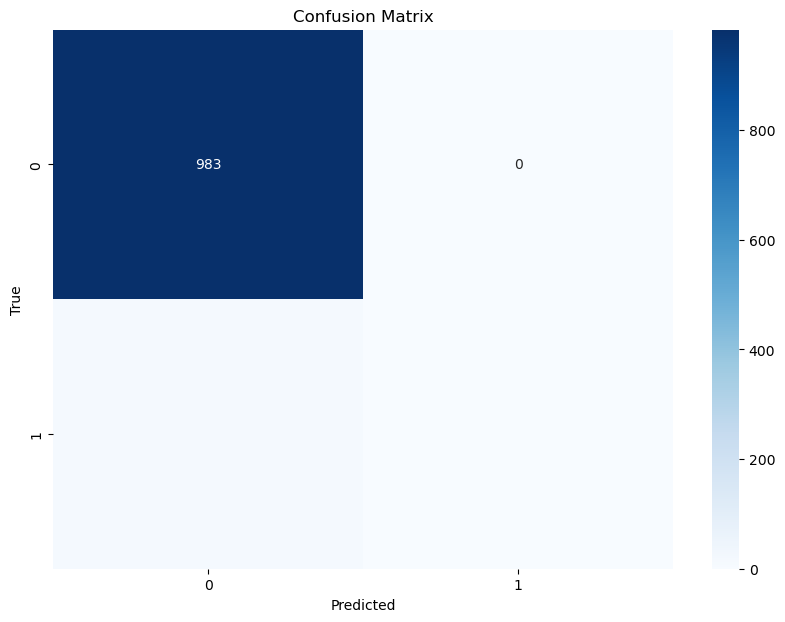

Cohen's Kappa: 0.0
Confusion Matrix:
[[983   0]
 [ 17   0]]


In [21]:
######################################## Performance Metrics ########################################

def calculate_kappa_and_confusion_matrix(y_true, y_pred):
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return kappa, cm

def evaluate_patient_eligibility_binary(patient_id, clinical_trials_incl, table_dataframes, eligibility_threshold=70):
    eligibility_scores = []
    tables_without_data = set()
    explanations = []
    
    for _, row in clinical_trials_incl.iterrows():
        criterion = row['Inclusion_Criteria']
        category = row['Category']
        relevant_tables = category_table_mapping.get(category, [])
        
        match_score, best_match_data, tables_without_data = fuzzy_match_criteria(patient_id, criterion, category, relevant_tables, table_dataframes, tables_without_data)
        eligibility_scores.append(match_score)
        
        # Generate explanation
        if match_score == 100:
            explanation = f"Perfect match found for criterion: {criterion}"
        elif match_score > 80:
            explanation = f"Strong match found for criterion: {criterion}"
        elif match_score > 60:
            explanation = f"Moderate match found for criterion: {criterion}"
        elif match_score > 40:
            explanation = f"Weak match found for criterion: {criterion}"
        elif match_score > 0:
            explanation = f"Very weak match found for criterion: {criterion}"
        else:
            explanation = f"No match found for criterion: {criterion}"
        
        if best_match_data:
            explanation += f"\nBest matching patient data: {best_match_data}"
        
        if set(relevant_tables) & tables_without_data:
            missing_tables = set(relevant_tables) & tables_without_data
            explanation += f"\nNote: No data found in tables: {', '.join(missing_tables)}"
        
        explanations.append(explanation)

    overall_eligibility = np.mean(eligibility_scores)
    is_eligible = overall_eligibility >= eligibility_threshold
    
    return is_eligible, overall_eligibility, eligibility_scores, tables_without_data, explanations

def evaluate_sample_population(sample_patients, clinical_trials_incl, table_dataframes, expert_decisions):
    algorithm_decisions = []
    
    for patient_id in sample_patients:
        is_eligible, _, _, _, _ = evaluate_patient_eligibility_binary(patient_id, clinical_trials_incl, table_dataframes)
        algorithm_decisions.append(is_eligible)
    
    # Calculate Cohen's Kappa and confusion matrix
    kappa, cm = calculate_kappa_and_confusion_matrix(expert_decisions, algorithm_decisions)
    
    print(f"Cohen's Kappa: {kappa}")
    print("Confusion Matrix:")
    print(cm)
    
    return kappa, cm

def get_random_sample_patients(demographics_df, sample_size=100):
    """
    Get a random sample of patient IDs from the demographics table.
    
    :param demographics_df: DataFrame containing patient demographic information
    :param sample_size: Number of patients to sample (default: 100)
    :return: List of randomly sampled patient IDs
    """
    # Ensure the sample size is not larger than the number of patients
    sample_size = min(sample_size, len(demographics_df))
    
    # Assuming the patient ID column is named 'patient_id'
    # Adjust this if your column name is different
    return demographics_df['patientid'].sample(n=sample_size, random_state=42).tolist()

# Create the expert_decisions array
sample_patients = get_random_sample_patients(DEMOGRAPHICS, sample_size=1000)

# Mark eligible patients as 1 and others as 0
expert_decisions = [1 if patient_id in eligible_patient_ids else 0 for patient_id in sample_patients]

print(clinical_trials_incl)
# # Get a random sample of patient IDs
# sample_patients = get_random_sample_patients(DEMOGRAPHICS, sample_size=100)

# # For this example, we'll generate random expert decisions
# # In a real scenario, you would replace this with actual expert assessments
# expert_decisions = np.random.randint(0, 2, len(sample_patients))

# Evaluate the sample population
kappa, cm = evaluate_sample_population(sample_patients, clinical_trials_incl, table_dataframes, expert_decisions)

In [ ]:
################################################################################################################################################################

In [ ]:
################################################################################################################################################################

In [12]:
print(DIAGNOSIS[DIAGNOSIS['targetdiagnosisgroup'].str.contains('Lung', case=False, na=False)])

     clientid                             patientid  \
748    CA0026  294CAE76-8964-46C5-8FED-9971C96E25D4   
749    CA0026  A61570CF-14F4-4CF6-B0BC-E91509F113CC   
750    CA0026  12586DF5-081F-4A99-BA34-4F2BAC0B64DD   
751    CA0026  8181E53E-C0D5-4999-8094-9EF4AA38B2D5   
752    CA0026  C3BC10E4-EB63-4878-AFA8-DC52A4F0C041   
753    CA0026  AC2793B2-5427-4200-A07E-1006E87B0418   
754    CA0026  81AED312-6EC3-4E2D-8165-58648FA341AC   
755    CA0026  06299E62-F5B6-4574-B0EE-F944074D6C2B   
756    CA0026  1175F541-E77F-422C-AF11-3DFA8DC0F1B3   
895    CA0026  5A734E84-B882-4C9D-BBCF-3FB915258D6A   
1231   CA0026  1E71D76A-489A-41C3-8D3C-3CA2B0D4BE1B   
1232   CA0026  C0365A07-7A5F-4BCE-BB7F-20B0D2092369   
1233   CA0026  3DA798A9-E309-45A6-92A6-BBD5910F3D6B   
1234   CA0026  26F3A31D-B1C2-46BD-8782-339F26A9762D   
1235   CA0026  EB9E321E-D811-447E-9123-E7D4A9C81BC6   
1236   CA0026  34B74BC9-C20B-4690-9976-809261D41499   
1237   CA0026  86F96AD3-1CD5-4B67-8543-CE8D95ABB14D   
1238   CA0

In [15]:
######################################## Chunk Model ########################################

# Create Chunks
def process_criteria(row):
    criteria = row['Inclusion_Criteria']
    chunks = re.split(r',\s*(?:and\s+)?', criteria)
    return pd.Series({f'chunk_{i+1}': chunk.strip() for i, chunk in enumerate(chunks)})

# Process the criteria and create a new dataframe with the chunks
chunks_inclusioncriteria = clinical_trials.apply(process_criteria, axis=1)

# Add the trial_id to the chunks dataframe
chunks_inclusioncriteria.insert(0, 'Trial_ID', clinical_trials['Trial_ID'])

# Reset the index to make sure it's consistent
chunks_inclusioncriteria = chunks_inclusioncriteria.reset_index(drop=True)

# Download and load the English model
nlp = spacy.load("en_core_web_sm")

def classify_chunk(chunk):
    doc = nlp(chunk)
    
    # Define rules for classification
    if any(token.text.lower() in ["age", "year", "old"] for token in doc):
        return "age"
    elif any(token.text.lower() in ["diagnosis", "condition", "disease"] for token in doc):
        return "diagnosis"
    elif any(token.text.lower() in ["treatment", "therapy", "medication"] for token in doc):
        return "treatment"
    elif any(token.text.lower() in ["gender", "sex", "female", "male"] for token in doc):
        return "gender"
    elif any(token.ent_type_ == "CONDITION" for token in doc):
        return "diagnosis"
    # Add more rules as needed
    else:
        return "other"

# Function to process and classify all chunks for a row
def process_and_classify_row(row):
    results = {'Trial_ID': row['Trial_ID']}
    for col in row.index:
        if col.startswith('chunk_') and pd.notna(row[col]):
            chunk = row[col]
            classification = classify_chunk(chunk)
            results[f'{col}_classification'] = classification
    return pd.Series(results)

# Apply the processing and classification to each row
classified_chunks = chunks_inclusioncriteria.apply(process_and_classify_row, axis=1)

# Print the result
print(classified_chunks)

   Trial_ID chunk_1_classification chunk_2_classification  \
0         1                    age              treatment   
1         2                  other                  other   
2         3                  other                  other   
3         4                    age                  other   
4         5                    age                  other   
5         6                    age                    NaN   
6         7                 gender                    age   
7         8                    age                  other   

  chunk_3_classification chunk_4_classification chunk_5_classification  \
0                  other                    NaN                    NaN   
1                  other                    NaN                    NaN   
2              treatment                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4              treatment                    NaN                    NaN   
5     